In [2]:
import tensorflow as tf
tf.contrib.resampler

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.4 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 432, got 412
  return f(*args, **kwds)


<module 'tensorflow.contrib.resampler' from '/home/pi/.local/lib/python3.5/site-packages/tensorflow/contrib/resampler/__init__.py'>

In [3]:
import os 

# All of the models come from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
#    (the link given in the lab handout)
ROOT_MODEL_DIR = os.path.join(os.getcwd(), "models")

# These MODEL_NAME's were able to be installed on the Pi:
# attr {
#   key: "dtype"
#   value {
#     type: DT_UINT8
#   }
# }

# attr {
#   key: "shape"
#   value {
#     shape {
#       dim {
#         size: -1
#       }
#       dim {
#         size: -1
#       }
#       dim {
#         size: -1
#       }
#       dim {
#         size: 3
#       }
#     }
#   }
# }
MODEL_NAME = "ssdlite_mobilenet_v2_coco_2018_05_09" 

# MODEL_NAME = "ssd_mobilenet_v2_quantized_300x300_coco_2018_09_14"

# The frozen graph filename depends on the specific model used
# frozen_graph_filename = os.path.join(ROOT_MODEL_DIR, MODEL_NAME, "tflite_graph.pb")
frozen_graph_filename = os.path.join(ROOT_MODEL_DIR, MODEL_NAME, "frozen_inference_graph.pb")


# Running this will have lab_graph contain the model's Graph
lab_graph = tf.Graph()
with lab_graph.as_default():
    worker_graph_def = tf.GraphDef()
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as graph_file:
        worker_graph_def.ParseFromString(graph_file.read())
        
    tf.import_graph_def(worker_graph_def, name='')

In [4]:

# With a different notebook, I converted the COCO id -> class mapping from
#   https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt
# into a JSON format since the .pbtxt format would require the tensorflow "models" Git repo
# to deserialize that .pbtxt file

# So this makes MIKE_COCO_LABEL_MAP a dictionary from id (integer) to class (string, like 'person', 'stop_sign')
import json
with open('./coco_label_map.json', 'r') as f:
    MIKE_COCO_LABEL_MAP = json.load(f)
    MIKE_COCO_LABEL_MAP = {int(k):v for (k,v) in MIKE_COCO_LABEL_MAP.items()}

In [7]:
[n.name + "=>" + n.op for n in worker_graph_def.node if n.op in ("Softmax", "Placeholder")]

['image_tensor=>Placeholder']

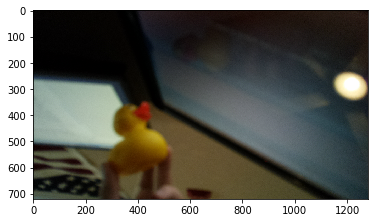

In [24]:
from picamera import PiCamera
import time
import numpy as np

VERTICAL_RESOLUTION = 720
HORIZONTAL_RESOLUTION = 1280

# Let's quick get an actual image from the Pi, remembering to flip the resolutions for the numpy array
capture_arr = np.empty((VERTICAL_RESOLUTION, HORIZONTAL_RESOLUTION, 3), dtype=np.uint8)
with PiCamera() as camera:

    camera.resolution = (HORIZONTAL_RESOLUTION, VERTICAL_RESOLUTION)
    camera.capture(capture_arr, 'rgb')

import matplotlib.pyplot as plt
plt.imshow(capture_arr)

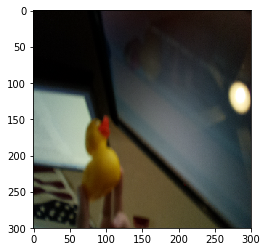

In [25]:
import cv2
RESIZED_HORIZONTAL_RESOLUTION = 300
RESIZED_VERTICAL_RESOLUTION = 300
# Doing some resizing to 300x300 image since that is the resolution the model was trained on

resized_capture_arr = cv2.resize(capture_arr, (RESIZED_HORIZONTAL_RESOLUTION, RESIZED_VERTICAL_RESOLUTION), interpolation=cv2.INTER_LINEAR)
plt.imshow(resized_capture_arr)

In [8]:
# This code is modified from the object recognition example that the Lab document linked to


# let's try to run the image through our Tensorflow graph
# Session only needs to be initialized once
sess = tf.Session(graph=lab_graph)
# Most tutorials add this step, but since we specify a graph to the Session, we don't initialize global variables
# sess.run(tf.global_variables_initializer())

In [26]:
# name "image_tensor" taken by looking for Placeholder tensors in the loaded graph

# input image tensor
image_tensor = lab_graph.get_tensor_by_name("image_tensor:0")
# percentage-based bounding boxes for detected objects
boxes = lab_graph.get_tensor_by_name("detection_boxes:0")
# classification scores for each detection (from 0 to 1)
scores = lab_graph.get_tensor_by_name("detection_scores:0")
# integer ids of the detected classes
classes = lab_graph.get_tensor_by_name("detection_classes:0")
# number of non-zero score detections
num_detections = lab_graph.get_tensor_by_name("num_detections:0")



# Give them model a batch size of just one image
feed_dict = {
    image_tensor: np.expand_dims(resized_capture_arr, axis=0)
}

In [27]:
# Perform inference
# The first image ran for the session will take a while, 
#   but after that a 300x300 image performed detection in roughly 800ms
%time x = sess.run([boxes, scores, classes, num_detections], feed_dict=feed_dict)

CPU times: user 2.04 s, sys: 202 ms, total: 2.24 s
Wall time: 816 ms


In [28]:
# Unpacking the results
res_boxes, res_scores, res_classes, res_num_detections = x
# Use np.squeeze to remove single-dimensonal entries from the sahpe of the array
res_boxes, res_scores, res_classes, res_num_detections = map(
    np.squeeze, [res_boxes, res_scores, res_classes, res_num_detections])
res_classes = res_classes.astype(int)
res_num_detections = int(res_num_detections)

In [29]:
print("Number of detections {0}".format(res_num_detections))
print()

# Don't consider an object detected unless its probability is > this threshold
SCORE_THRESHOLD = 0.2



for idx in range(res_num_detections):
    
    detected_score = res_scores[idx]
    if detected_score < SCORE_THRESHOLD:
        continue
        
    detected_class = MIKE_COCO_LABEL_MAP[res_classes[idx]]
    print("Detected the class {0}".format(detected_class))
    
    print("With score {0}".format(detected_score))
    
    print("Bounding box in percentages of resized image resolution")
    print(res_boxes[idx])
    
    print()

Number of detections 2

Detected the class teddy
With score 0.7484595775604248
Bounding box in percentages of resized image resolution
[0.48438275 0.20424879 0.95999205 0.41939843]

Detected the class tv
With score 0.3773784935474396
Bounding box in percentages of resized image resolution
[0.01044193 0.05571136 0.9911541  0.985093  ]



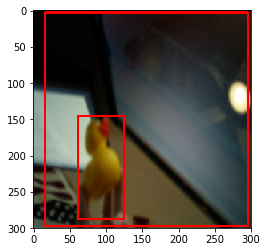

In [30]:
foo = resized_capture_arr.copy()

import math
for idx in range(res_num_detections):
    
    bounds = res_boxes[idx]
    
    width = foo.shape[0]
    height = foo.shape[1]
    
    pt1_x = math.floor(bounds[0] * width)
    pt1_y = math.floor(bounds[1] * height)
    
    pt2_x = math.floor(bounds[2] * width)
    pt2_y = math.floor(bounds[3] * height)
    
    
    # x and y are swapped from Tensorflow's bounds to opencv coordinates
    cv2.rectangle(foo, (pt1_y, pt1_x), (pt2_y, pt2_x), (255, 0, 0), thickness=2)
    
    # WRONG!
    # cv2.rectangle(foo, (pt1_x, pt1_y), (pt2_x, pt2_y), (255, 0, 0), thickness=2)

    
    
    
    
plt.imshow(foo)